<a href="https://colab.research.google.com/github/fAikoH-dot/TCC-v1/blob/main/prophet/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# !pip install prophet

In [21]:
# %pip install python-bcb

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

C:\Users\hamatsu\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
df = pd.read_csv('../../data library/Soja_v1.csv', sep=";")
df = df.sort_values(by='Data').reset_index(drop=True)
df.rename(columns={"Data":"ds", "Estadual":"y"}, inplace=True)
df.head()

,ds,Cultivo,y,País,Id,Último,Abertura,Máxima,Mínima
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0


In [49]:
omc = pd.read_csv("../../data library/indice_omc.csv", sep = ",")
omc.head()

,Data,Index
0,2006-01-01,22
1,2006-02-01,2
2,2006-03-01,28
3,2006-04-01,22
4,2006-05-01,32


In [50]:
from bcb import PTAX
from bcb import currency

ptax = PTAX()

df_usd = currency.get(['USD'],
                  start='2004-03-01',
                  end='2024-09-01',
                  side='ask')

df_usd["Date"]=df_usd.index
df_usd["Month"] = df_usd["Date"].dt.month
df_usd["Year"] = df_usd["Date"].dt.year
df_usd["Day"] = 1
df_usd["Aux"] = df_usd["Year"].astype(str) +"-"+ df_usd["Month"].astype(str)
df_usd = df_usd.groupby("Aux").agg(
    USD = ("USD", "mean"),
    day = ("Day", "first"),
    month = ("Month", "first"),
    year = ("Year", "first"),
).reset_index(drop=True)

df_usd["Data"] = pd.to_datetime(df_usd[['year', 'month', 'day']])
df_usd = df_usd[["Data", "USD"]].sort_values(by="Data").reset_index(drop=True)

In [51]:
clima = pd.read_csv("../../data library/Clima/MT_dados.csv", sep=';')
clima.rename(columns={"PRECIPITACAO TOTAL":"precipitacao", "TEMPERATURA MEDIA":"temperatura"}, inplace=True)

clima["precipitacao"] = clima.precipitacao.str.replace(',', '.')
clima["temperatura"] = clima.temperatura.str.replace(',', '.')

clima.bfill(inplace=True)
clima.head()

,Data Medicao,precipitacao,temperatura
0,31/03/2004,175.4,24.9
1,30/04/2004,175.4,24.5
2,31/05/2004,23,21.7
3,30/06/2004,18.8,22.1
4,31/07/2004,38,22.2


In [52]:
df["USD"] = df_usd["USD"]
df["Precipitacao"] = clima["precipitacao"].astype(float)
df["Temperatura"] = clima["temperatura"].astype(float)
df['lag_Estadual'] = df['y'].shift(1)
df['lag_Estadual'] = df['lag_Estadual'].bfill()
df["omc"] = omc["Index"]
df.head()

,ds,Cultivo,y,País,Id,Último,Abertura,Máxima,Mínima,USD,Precipitacao,Temperatura,lag_Estadual,omc
0,2004-03-01,Soja,45.3777,50.0455,0,1.034,1.000,1.064,92600.0,2.905457,175.4,24.9,45.3777,22.0
1,2004-04-01,Soja,45.9456,48.7279,0,81400.000,1.036,1.063,81200.0,2.905985,175.4,24.5,45.3777,2.0
2,2004-05-01,Soja,44.8723,47.4930,0,89300.000,82800.000,94000.000,0.0,3.100419,23.0,21.7,45.9456,28.0
3,2004-06-01,Soja,38.5913,40.7781,0,59950.000,89200.000,1.035,59900.0,3.129148,18.8,22.1,44.8723,22.0
4,2004-07-01,Soja,34.0818,37.5474,0,62725.000,59100.000,71200.000,56500.0,3.036777,38.0,22.2,38.5913,32.0


In [8]:
def plot_predictions(testing_dates, y_test, prediction):
    df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
    _, ax = plt.subplots(figsize=(10, 5))
    df_test.plot(ax=ax, label="Actual", x="date", y="actual")
    df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
    plt.legend(["Actual", "Prediction"])
    plt.show()

In [9]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"RMSE: {root_mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  print(f"R-Squared: {r2_score(y_test, prediction)}")

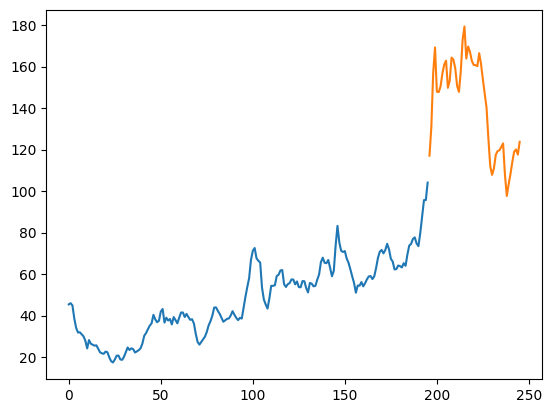

In [53]:
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:len(df)]

test_dates = test.ds

plt.plot(train.y)
plt.plot(test.y)

# Univariado

In [77]:
m = Prophet()
m.fit(train)

# m.params

01:24:35 - cmdstanpy - INFO - Chain [1] start processing
01:24:36 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
forecast = m.predict(test)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,76.955598,66.996408,86.623936
1,2020-09-01,78.499337,68.830399,89.424818
2,2020-10-01,78.571636,68.539743,89.563786
3,2020-11-01,78.858561,68.042889,89.067416
4,2020-12-01,78.266230,68.637274,88.516138


In [79]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

,ds,y,yhat
0,2020-08-01,117.0222,76.955598
1,2020-09-01,130.8449,78.499337
2,2020-10-01,156.7972,78.571636
3,2020-11-01,169.1946,78.858561
4,2020-12-01,147.9145,78.266230


In [80]:
test_dates = pd.to_datetime(test_dates)
test_dates

196   2020-08-01
197   2020-09-01
198   2020-10-01
199   2020-11-01
200   2020-12-01
201   2021-01-01
202   2021-02-01
203   2021-03-01
204   2021-04-01
205   2021-05-01
206   2021-06-01
207   2021-07-01
208   2021-08-01
209   2021-09-01
210   2021-10-01
211   2021-11-01
212   2021-12-01
213   2022-01-01
214   2022-02-01
215   2022-03-01
216   2022-04-01
217   2022-05-01
218   2022-06-01
219   2022-07-01
220   2022-08-01
221   2022-09-01
222   2022-10-01
223   2022-11-01
224   2022-12-01
225   2023-01-01
226   2023-02-01
227   2023-03-01
228   2023-04-01
229   2023-05-01
230   2023-06-01
231   2023-07-01
232   2023-08-01
233   2023-09-01
234   2023-10-01
235   2023-11-01
236   2023-12-01
237   2024-01-01
238   2024-02-01
239   2024-03-01
240   2024-04-01
241   2024-05-01
242   2024-06-01
243   2024-07-01
244   2024-08-01
245   2024-09-01
Name: ds, dtype: datetime64[ns]

In [81]:
final_df["ds"] = pd.to_datetime(final_df["ds"])
final_df

,ds,y,yhat
0,2020-08-01,117.0222,76.955598
1,2020-09-01,130.8449,78.499337
2,2020-10-01,156.7972,78.571636
3,2020-11-01,169.1946,78.858561
4,2020-12-01,147.9145,78.266230
5,2021-01-01,147.6618,76.188292
6,2021-02-01,150.3854,74.278958
7,2021-03-01,156.5591,76.920358
8,2021-04-01,160.8866,77.492799
9,2021-05-01,162.8333,79.986541


In [88]:
final_df_test = final_df[-49:]
# final_df_test

In [89]:
final_df_test

,ds,y,yhat
1,2020-09-01,130.8449,78.499337
2,2020-10-01,156.7972,78.571636
3,2020-11-01,169.1946,78.858561
4,2020-12-01,147.9145,78.266230
5,2021-01-01,147.6618,76.188292
6,2021-02-01,150.3854,74.278958
7,2021-03-01,156.5591,76.920358
8,2021-04-01,160.8866,77.492799
9,2021-05-01,162.8333,79.986541
10,2021-06-01,149.7397,81.449525


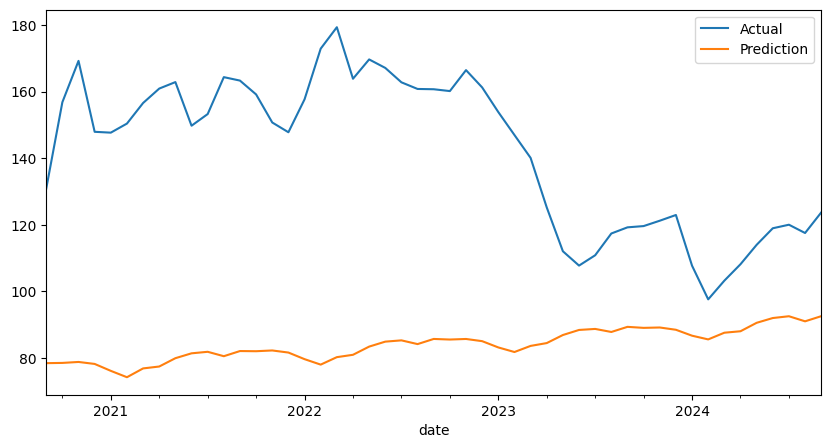

MAE: 58.02343853471323
RMSE: 63.54917754141358
MAPE: 0.38796996616788876
R-Squared: -6.89469083368254


In [90]:
plot_predictions(final_df_test.ds, final_df_test.y, final_df_test.yhat)
evaluate_model(final_df_test.y, final_df_test.yhat)

# Multivariado

In [54]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

# m.params

16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
test_1 = test[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']]
test_1.head()

,ds,USD,País,Último,Máxima,lag_Estadual
196,2020-08-01,5.280191,113.3375,95250.00000,96688.00000,104.0607
197,2020-09-01,5.461233,128.3004,1.02175,1.04650,117.0222
198,2020-10-01,5.399486,147.4121,1.05688,1.09388,130.8449
199,2020-11-01,5.625790,157.3982,1.16875,1.19962,156.7972
200,2020-12-01,5.417835,140.9301,1.31025,1.32060,169.1946


In [36]:
# future = m.make_future_dataframe(periods=len(test_1), freq='MS')
# future.head()

In [56]:
forecast = m.predict(test_1)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,111.139290,109.250369,113.071324
1,2020-09-01,128.175342,126.307040,130.176481
2,2020-10-01,147.863654,145.863206,149.772437
3,2020-11-01,160.387330,158.455368,162.270358
4,2020-12-01,145.899544,143.985000,147.670596


In [57]:
test.reset_index(inplace=True, drop=True)
final_df = test[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = forecast['yhat']
final_df.head()

,ds,y,País,USD,yhat
0,2020-08-01,117.0222,113.3375,5.280191,111.139290
1,2020-09-01,130.8449,128.3004,5.461233,128.175342
2,2020-10-01,156.7972,147.4121,5.399486,147.863654
3,2020-11-01,169.1946,157.3982,5.625790,160.387330
4,2020-12-01,147.9145,140.9301,5.417835,145.899544


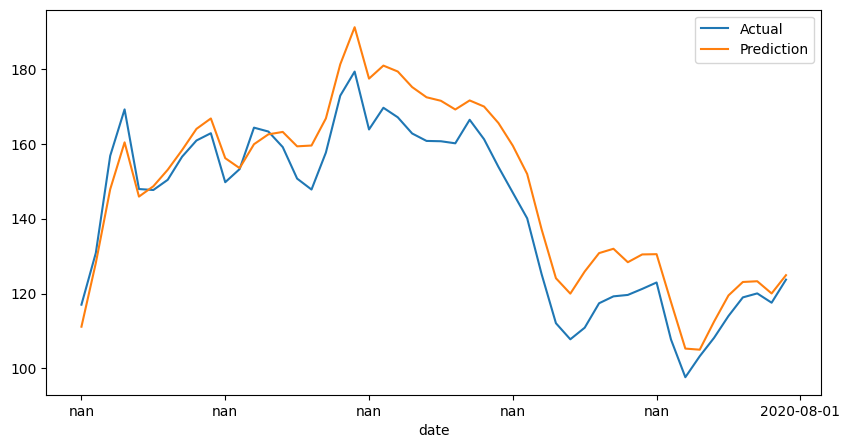

MAE: 7.611000337913269
RMSE: 8.693223839572813
MAPE: 0.0552276519622423
R-Squared: 0.8528648558600913


In [58]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

In [59]:
aux_var = ['USD', 'País', 'Último', 'Máxima', 'lag_Estadual']
future_dates = m.make_future_dataframe(periods=((len(test_1))+24), freq="MS")

In [60]:
extended_df = future_dates.copy()

for i in aux_var:
    train_aux = train[['ds', i]].copy()
    train_aux.rename(columns={i:"y"}, inplace=True)

    m = Prophet()
    m.fit(train_aux)
    forecast = m.predict(future_dates)
    
    extended_df[i] = forecast["yhat"]

extended_df

16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:01 - cmdstanpy - INFO - Chain [1] start processing
16:18:01 - cmdstanpy - INFO - Chain [1] done processing
16:18:01 - cmdstanpy - INFO - Chain [1] start processing
16:18:01 - cmdstanpy - INFO - Chain [1] done processing
16:18:01 - cmdstanpy - INFO - Chain [1] start processing
16:18:01 - cmdstanpy - INFO - Chain [1] done processing
16:18:01 - cmdstanpy - INFO - Chain [1] start processing
16:18:01 - cmdstanpy - INFO - Chain [1] done processing


,ds,USD,País,Último,Máxima,lag_Estadual
0,2004-03-01,2.814078,25.581313,35949.356883,29380.735440,20.796011
1,2004-04-01,2.785586,25.091087,29875.044112,23145.454852,20.960161
2,2004-05-01,2.809846,26.178504,30261.996334,35065.663843,21.544774
3,2004-06-01,2.843009,27.206649,28756.628044,24576.524429,24.020413
4,2004-07-01,2.775656,28.134790,29149.423810,23019.412387,25.589320
...,...,...,...,...,...,...
265,2026-05-01,6.227675,100.375367,68582.216507,64435.949794,94.260163
266,2026-06-01,6.277252,101.594884,66885.153717,53768.473832,96.709218
267,2026-07-01,6.269313,102.278598,67812.561329,52355.724084,98.135074
268,2026-08-01,6.228821,101.261075,69331.860623,54414.332975,96.943966


In [61]:
m = Prophet()
m.add_regressor('USD')
m.add_regressor('País')
m.add_regressor('Último')
m.add_regressor('Máxima')
m.add_regressor('lag_Estadual')
m.fit(train)

16:18:04 - cmdstanpy - INFO - Chain [1] start processing
16:18:04 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
real_data = df[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']].copy()
final_date = df["ds"][-1:]
predicted_data = extended_df[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']][len(train)+len(test):]

real_data_2 = pd.concat([real_data, predicted_data], ignore_index=True)

In [63]:
test_2 = real_data_2[['ds', 'USD', 'País', 'Último', 'Máxima', 'lag_Estadual']][train_size:].reset_index(drop=True)
test_2.head()

,ds,USD,País,Último,Máxima,lag_Estadual
0,2020-08-01,5.280191,113.3375,95250.00000,96688.00000,104.0607
1,2020-09-01,5.461233,128.3004,1.02175,1.04650,117.0222
2,2020-10-01,5.399486,147.4121,1.05688,1.09388,130.8449
3,2020-11-01,5.625790,157.3982,1.16875,1.19962,156.7972
4,2020-12-01,5.417835,140.9301,1.31025,1.32060,169.1946


In [64]:
final_forecast = m.predict(test_2)
final_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2020-08-01,111.139290,109.119168,113.003523
1,2020-09-01,128.175342,126.228845,130.228634
2,2020-10-01,147.863654,145.863887,149.812018
3,2020-11-01,160.387330,158.411348,162.322192
4,2020-12-01,145.899544,143.956799,147.889471


In [65]:
test_2.reset_index(inplace=True, drop=True)
test_2['y'] = test['y']
test_2.fillna(0, inplace=True)
final_df = test_2[["ds", "y", "País", "USD"]].copy()
final_df['yhat'] = final_forecast['yhat']
final_df.head()

,ds,y,País,USD,yhat
0,2020-08-01,117.0222,113.3375,5.280191,111.139290
1,2020-09-01,130.8449,128.3004,5.461233,128.175342
2,2020-10-01,156.7972,147.4121,5.399486,147.863654
3,2020-11-01,169.1946,157.3982,5.625790,160.387330
4,2020-12-01,147.9145,140.9301,5.417835,145.899544


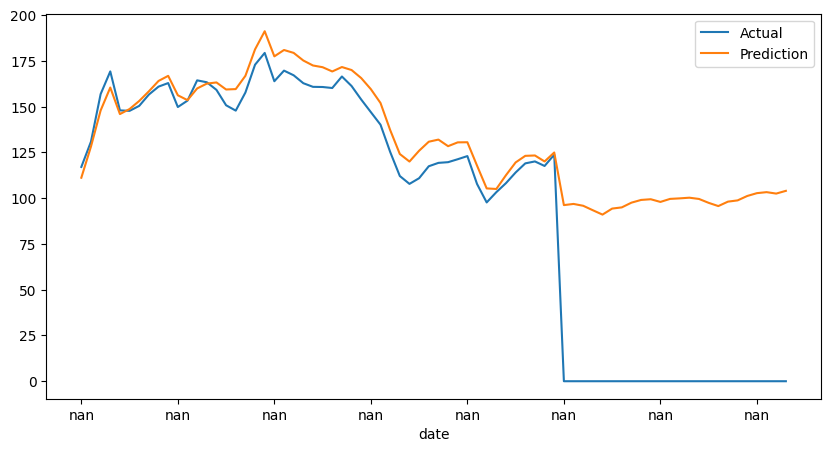

MAE: 37.020466532178055
RMSE: 56.45868997547407
MAPE: 1.4356529287011328e+17
R-Squared: 0.3274720408896755


In [66]:
plot_predictions(test_dates, final_df.y, final_df.yhat)
evaluate_model(final_df.y, final_df.yhat)

In [48]:
final_df.to_csv('../../Soja/Soja_Resultados.csv', sep=',', index=False)